In [1]:
### Import Packages ###
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from deepxde.backend import tf


%matplotlib widget


Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



In [2]:
lab_data = np.genfromtxt("Lab_data.csv",delimiter=',')
lab_data = np.delete(lab_data,0,0)
x_obs = lab_data[:,0]
u_obs = lab_data[:,1]-92.0 #shift everything down by 92 degrees. Closer to 1 = Faster Learning

In [66]:
##########################################################
### This block: Set up the model. Geometry, governing  ###
### equation(s), BC's                ###
##########################################################


### Define geometry and material properties
l_pcd=2.286 #Length of PCD
l_sub=10.93 #Length of Substrate
#temp_amb=20.0-92.0 #Ambient temperature (for convection)
flux=dde.Variable(1.0) #The Flux--it's constant here
#h=dde.Variable(1.0) #Convection coefficient to solve for
k_pcd=dde.Variable(5.0)
k_sub=1 #substrate conductivity
T_base = -1 #Temperature at base of substrate
T_top = 1 #Temperature at top of PCD table

### Define Geometry ###
geom_substrate = dde.geometry.Interval(-l_sub,0)
geom_pcd = dde.geometry.Interval(0,l_pcd)
geom = dde.geometry.Interval(-l_sub,l_pcd)

### Define PDE Residual ###
def pde(x,u):    
    X = tf.cast(x[:, 0:1], dtype=tf.float32) #Transform x into float32. These are training x?
    condition=tf.math.less(X,0.0) #Returns True if x<0, False if x>=0
    k_matl=tf.where(condition,tf.ones_like(X) * k_sub,tf.ones_like(X) * k_pcd) #Return 100 if < 0 (substrate conductivity),
        #500 if > 0 (PCD conductivity)
    
    du_xx = dde.grad.hessian(u,x,i=0,j=0) #This equation is valid everywhere
    du_x  = dde.grad.jacobian(u,x,i=0,j=0)
    
    print(condition)

    return k_matl * du_x + flux #) + abs(du_xx)
    
### Define location of Robin BC at x=-l_sub: ###
def boundary_l(x, on_boundary):
    return on_boundary and np.isclose(x[0],-l_sub)

### Define location of Dirichlet (temperature) BC at x=l_pcd
def boundary_r(x, on_boundary):
    return on_boundary and np.isclose(x[0],l_pcd)

### Define function to return u(x) = T_base @ x=-l_sub
def robin_base(x,y):
    return -flux/k_sub

### Define function to return u(x) = T_top @ x= l_pcd
def robin_top(x,y):
    return -flux/k_pcd

### Define Dirichlet (temperature) BC ###
bc_r= dde.icbc.RobinBC(geom, robin_top, boundary_r)

### Define Robin BC: Base
bc_l = dde.icbc.RobinBC(geom, robin_base, boundary_l)

### Define lab data as a PointSetBC
observe_u = dde.icbc.PointSetBC(np.array(x_obs).reshape(len(x_obs),1),np.array(u_obs).reshape(len(u_obs),1),component=0)

### Then, the pde problem is: ###

data = dde.data.PDE(geom, pde,[observe_u] , 14, 2, num_test=20) #bc_r
#geometry, pde residual, BC's, # of training pts sampled inside domain, # of training pts samples @ bnds,...
# of pts for testing PDE residual

Compiling model...
Building feed-forward neural network...
'build' took 0.204684 s

Tensor("Less_53:0", shape=(None, 1), dtype=bool)
Tensor("Less_54:0", shape=(None, 1), dtype=bool)
'compile' took 3.174356 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [6.07e+00, 4.39e-01]    [5.87e+00, 4.39e-01]    []  
1000      [3.06e-01, 3.14e-01]    [4.20e-01, 3.14e-01]    []  
2000      [3.11e-02, 6.92e-02]    [7.69e+00, 6.92e-02]    []  
3000      [9.21e-03, 2.32e-02]    [3.00e+00, 2.32e-02]    []  
4000      [1.19e-03, 6.51e-03]    [8.29e-01, 6.51e-03]    []  
5000      [1.75e-04, 4.57e-03]    [3.90e-01, 4.57e-03]    []  
6000      [8.43e-05, 4.45e-03]    [3.16e-01, 4.45e-03]    []  
7000      [7.51e-05, 4.43e-03]    [2.83e-01, 4.43e-03]    []  
8000      [7.22e-05, 4.41e-03]    [2.56e-01, 4.41e-03]    []  
9000      [4.14e-04, 4.96e-03]    [2.37e-01, 4.96e-03]    []  
10000     [6.69e-05, 4.39e-03]    [1.87e-01, 4

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
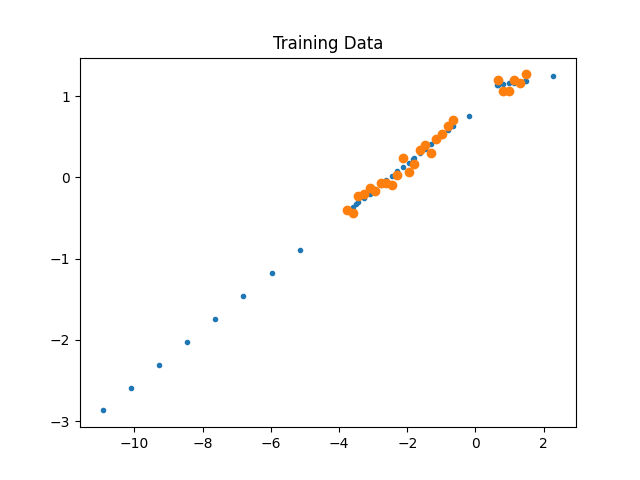

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
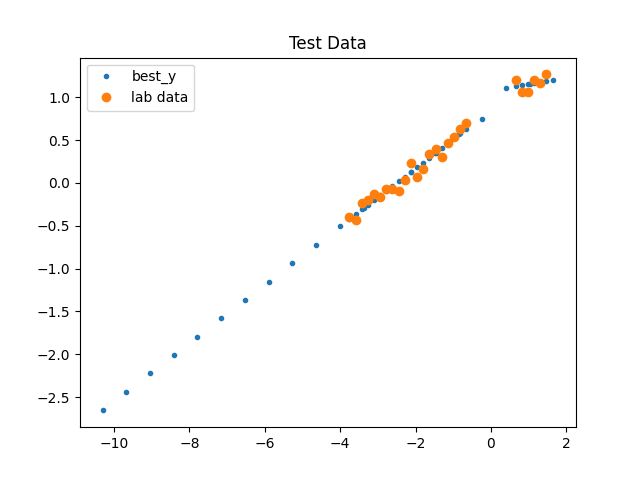

In [68]:
#######################################
### This block builds the model and ###
### trains the neural network       ###
#######################################
hidden_layer_size=20
num_hidden_layers=10
activation='tanh'
learning_rate=0.001
num_epochs=10000

### Build Model ###
layer_size = [1] + [hidden_layer_size] * num_hidden_layers + [1] #First layer is [1] for 1d problem, [2] for 2d problem, etc
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

#### These lines apply hard boundary condition 
# def  output_transform(x, y):
#     return (1 - x) * y + 100

# net.apply_output_transform(output_transform) #The network output is transformed so that u(1)=100 always. The transform
# is non-physical, arbitrary, but it doesn't matter because the PINN will calculate error on the TRANSFORMED output to 
# match the governing equations and Robin (Convection) bc

model = dde.Model(data, net)

### Compile Model ###
model.compile("adam", lr=learning_rate,loss_weights=[6,1])
variable_flux = dde.callbacks.VariableValue(flux, period=200, filename="variable_flux.dat")
variable_kpcd = dde.callbacks.VariableValue(k_pcd, period=200, filename="variable_kpcd.dat")

### Train Model ###
losshistory, train_state = model.train(epochs=num_epochs, callbacks=[variable_flux, variable_kpcd]) 

### Plot and save output ###
dde.saveplot(losshistory, train_state, issave=False, isplot=False)

plt.figure()
plt.title('Training Data')
plt.plot(train_state.X_train,train_state.y_pred_train,'.')
plt.plot(x_obs,u_obs,'o')
plt.figure()
plt.title('Test Data')
plt.plot(train_state.X_test,train_state.best_y,'.')
plt.plot(x_obs,u_obs,'o')
plt.legend(['best_y','lab data'])

[-0.34092343]
[4.9063697]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
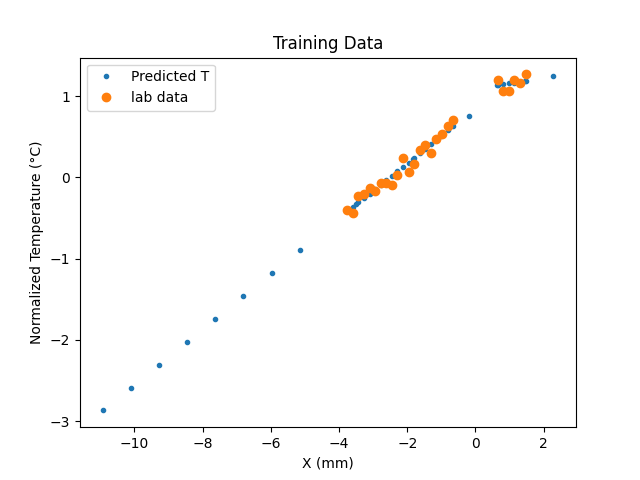

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
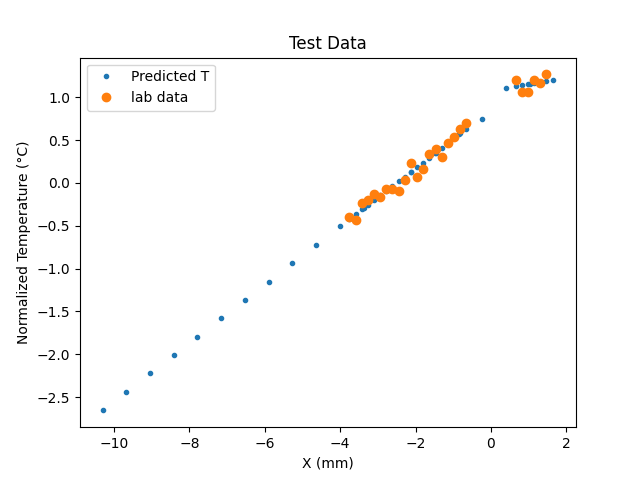

In [73]:
plt.figure()
plt.title('Training Data')
plt.plot(train_state.X_train,train_state.y_pred_train,'.')
plt.plot(x_obs,u_obs,'o')
plt.legend(['Predicted T','lab data'])
plt.xlabel('X (mm)')
plt.ylabel('Normalized Temperature (°C)')

plt.figure()
plt.title('Test Data')
plt.plot(train_state.X_test,train_state.best_y,'.')
plt.plot(x_obs,u_obs,'o')
plt.legend(['Predicted T','lab data'])
plt.xlabel('X (mm)')
plt.ylabel('Normalized Temperature (°C)')

print(variable_flux.value)
print(variable_kpcd.value)

In [6]:
#### Building and Training, but in a for loop! Neato. ####
'''
hidden_layer_sizes=[20]
nums_hidden_layers=[10]
activation='tanh'
learning_rate=0.001
num_epochs=10000

for hidden_layer_size in hidden_layer_sizes:
    for num_hidden_layers in nums_hidden_layers:
        ### Build Model ###
        layer_size = [1] + [hidden_layer_size] * num_hidden_layers + [1] #First layer is [1] for 1d problem, [2] for 2d problem, etc
        initializer = "Glorot uniform"
        net = dde.nn.FNN(layer_size, activation, initializer)

        #### These lines apply hard boundary condition 
        def  output_transform(x, y):
            return (1 - x) * y + 100

        net.apply_output_transform(output_transform) #The network output is transformed so that u(1)=100 always. The transform
        # is non-physical, arbitrary, but it doesn't matter because the PINN will calculate error on the TRANSFORMED output to 
        # match the governing equations and Robin (Convection) bc. This is weird but I see why it works.

        model = dde.Model(data, net)

        ### Compile Model ###
        model.compile("adam", lr=learning_rate)

        ### Train Model ###
        losshistory, train_state = model.train(epochs=num_epochs) #losshistory, train_state = 
        
        ### Plot and save output ###
        fileprefix=str('HLSIZE'+str(hidden_layer_size)+'NHL'+str(num_hidden_layers)+'ACT'+activation+'LR'+str(learning_rate))
        dde.saveplot(losshistory, train_state, issave=True, isplot=True,
                     loss_fname=fileprefix+'loss.dat',
                     train_fname=fileprefix+'train.dat',
                     test_fname=fileprefix+'test.dat')
        
        #Training Time
        #Iteration of best state
        #x_test, y hat at best state
        #Train Loss @ best state
        #Test Loss @ best state

# plt.figure()
# plt.plot(train_state.X_train,train_state.y_pred_train,'.')
# plt.plot(train_state.X_test,train_state.best_y,'.')
# plt.legend(['Y_pred_train','best_y'])
'''

'\nhidden_layer_sizes=[20]\nnums_hidden_layers=[10]\nactivation=\'tanh\'\nlearning_rate=0.001\nnum_epochs=10000\n\nfor hidden_layer_size in hidden_layer_sizes:\n    for num_hidden_layers in nums_hidden_layers:\n        ### Build Model ###\n        layer_size = [1] + [hidden_layer_size] * num_hidden_layers + [1] #First layer is [1] for 1d problem, [2] for 2d problem, etc\n        initializer = "Glorot uniform"\n        net = dde.nn.FNN(layer_size, activation, initializer)\n\n        #### These lines apply hard boundary condition \n        def  output_transform(x, y):\n            return (1 - x) * y + 100\n\n        net.apply_output_transform(output_transform) #The network output is transformed so that u(1)=100 always. The transform\n        # is non-physical, arbitrary, but it doesn\'t matter because the PINN will calculate error on the TRANSFORMED output to \n        # match the governing equations and Robin (Convection) bc. This is weird but I see why it works.\n\n        model = dde.